In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
# Load the dataset
file_path = "/content/Superstore.xls"
df = pd.read_excel(file_path)

In [15]:
# Filter data for the "Office Supplies" category
office_supplies_data = df[df['Category'] == 'Office Supplies'].copy()

In [16]:
# Convert the 'Order Date' column to datetime and set it as the index
office_supplies_data['Order Date'] = pd.to_datetime(office_supplies_data['Order Date'])
office_supplies_data.set_index('Order Date', inplace=True)

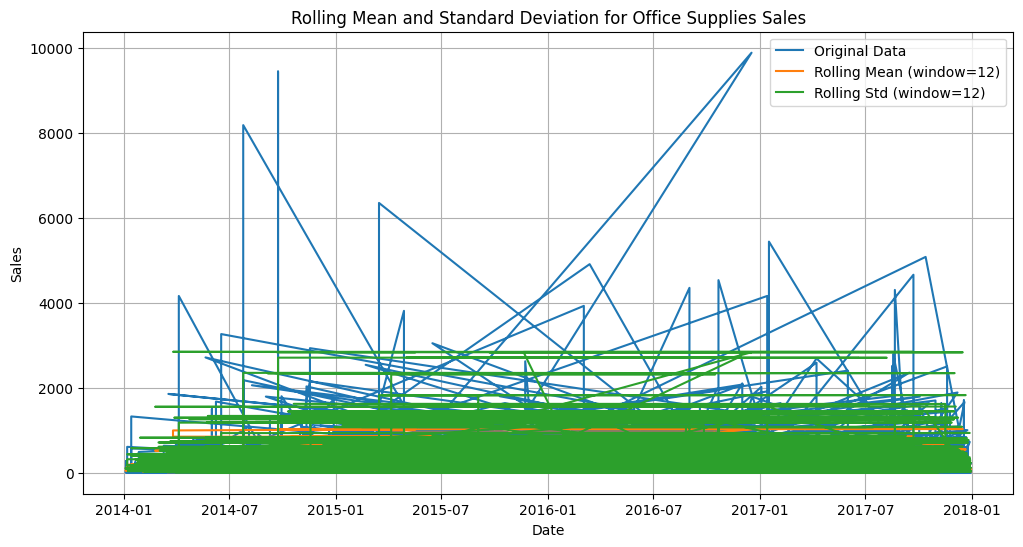

In [18]:
# a. Explore the dataset to report Stationarity using Rolling plots and Statistical Tests
# Plot the rolling mean and rolling standard deviation
rolling_mean = office_supplies_data['Sales'].rolling(window=12).mean()
rolling_std = office_supplies_data['Sales'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(office_supplies_data['Sales'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (window=12)')
plt.plot(rolling_std, label='Rolling Std (window=12)')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation for Office Supplies Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [19]:
# Perform Augmented Dickey-Fuller Test for stationarity
result = adfuller(office_supplies_data['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -77.71812057109307
p-value: 0.0
Critical Values: {'1%': -3.4314358237753178, '5%': -2.8620198346625063, '10%': -2.567025413481173}


In [20]:
# b. Determine the order of differencing, d.
# Differencing to make the time series stationary
office_supplies_data['Sales_diff'] = office_supplies_data['Sales'].diff()
office_supplies_data.dropna(inplace=True)

In [21]:
# Perform Augmented Dickey-Fuller Test on the differenced data
result_diff = adfuller(office_supplies_data['Sales_diff'])
print("\nADF Statistic (After Differencing):", result_diff[0])
print("p-value (After Differencing):", result_diff[1])
print("Critical Values (After Differencing):", result_diff[4])


ADF Statistic (After Differencing): -22.435591917177966
p-value (After Differencing): 0.0
Critical Values (After Differencing): {'1%': -3.4314421710435847, '5%': -2.8620226390585444, '10%': -2.5670269063352666}


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


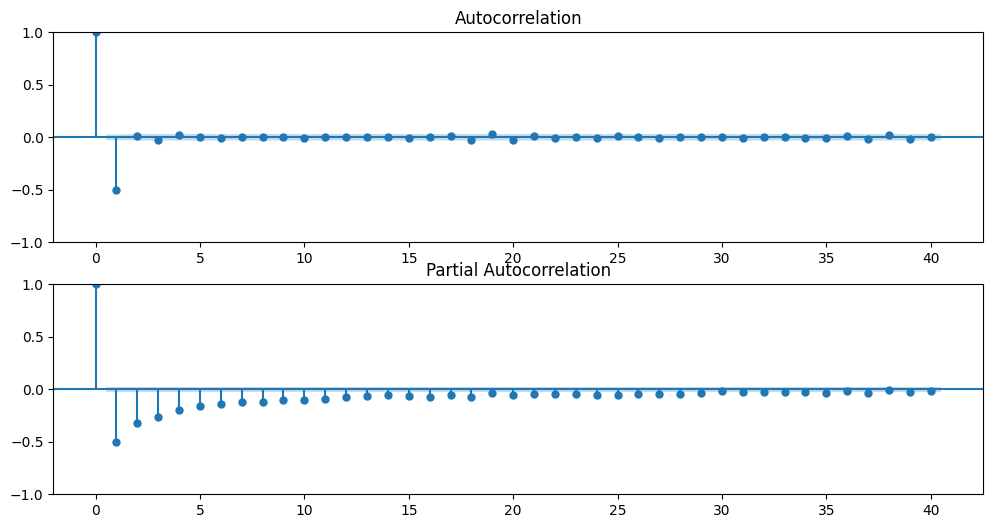

In [22]:
# c. Determine the order p for autoregressive process AR(p).
# We can use ACF and PACF plots to determine the order of p.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(office_supplies_data['Sales_diff'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(office_supplies_data['Sales_diff'], ax=plt.gca(), lags=40)
plt.show()

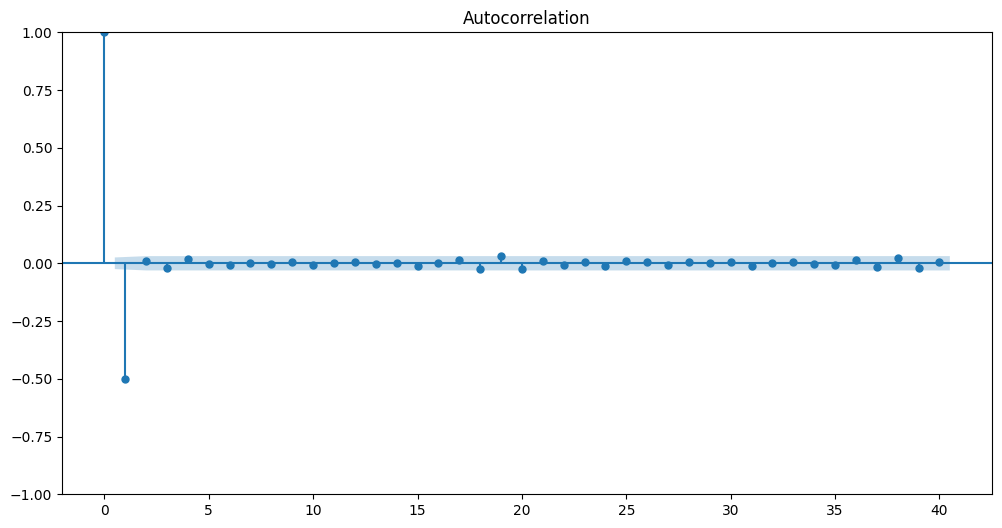

Order q for MA(q): 0


In [30]:
# d. Determine the order q for moving averages MA(q).
# Plot the ACF to identify significant spikes at different lag values
plt.figure(figsize=(12, 6))
plot_acf(office_supplies_data['Sales_diff'], ax=plt.gca(), lags=40, alpha=0.05)
plt.show()

# Manually find the last significant spike
q = 0
for lag in range(1, len(office_supplies_data)):
    acf_val = office_supplies_data['Sales_diff'].autocorr(lag)
    conf_int = 1.96 / (len(office_supplies_data) ** 0.5)
    if abs(acf_val) > conf_int:
        q = lag - 1
    else:
        break

print("Order q for MA(q):", q)

In [31]:
# e. Fit ARIMA (p, d, q) using determined values p, d, and q
p, d, q = 1, 1, 1
model = SARIMAX(office_supplies_data['Sales'], order=(p, d, q))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
# Forecast future sales
forecast_steps = 12  # Number of steps to forecast
forecast = results.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
# Print the forecasted values
print("\nForecasted Sales:")
print(forecast)


Forecasted Sales:
6025    119.365364
6026    119.523714
6027    119.523512
6028    119.523512
6029    119.523512
6030    119.523512
6031    119.523512
6032    119.523512
6033    119.523512
6034    119.523512
6035    119.523512
6036    119.523512
Name: predicted_mean, dtype: float64
